# Optimizing Ad Spend: A/B Test Analysis


## Introduction


### 1. Project Overview
In the competitive landscape of digital marketing, determining the true impact of an advertisement is crucial for optimizing budget allocation. This project analyzes the results of an A/B test from a marketing campaign to determine if the ads significantly increase user conversion rates compared to a Public Service Announcement (PSA) control group.

The dataset is from [Kaggle](https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing?resource=download) and consists of 588,101 users, split into two groups:

- **Experimental Group (Ad)**: Users exposed to the actual marketing advertisement.
- **Control Group (PSA)**: Users exposed to a placeholder Public Service Announcement to establish a baseline.

### 2. Problem Statement
Running ad campaigns is expensive. The core business question is not just **"did we get conversions?", but "did the ads cause a statistically significant lift in conversions compared to the baseline?"**
Without a proper control group, we cannot distinguish between the natural conversion rate of users and the specific effect of the ad. This analysis seeks to quantify that difference and determine if the campaign was a success.

### 3. Project Goals
The primary objective of this analysis is to evaluate the performance of the ad campaign and provide data-driven recommendations for future marketing strategies.


**Specific Goals:**

- **Quantify the Uplift**: Calculate the difference in conversion rates between the ad group and the psa group.
- **Hypothesis Testing**: Perform a **Chi-Square Test** to determine if the observed difference is statistically significant ($p < 0.05$).
- **Behavioral Analysis**: Analyze conversion trends by **Day of the Week** and **Hour of the Day** to identify peak engagement times.
- **Recommendation**: Provide actionable insights on whether to scale the campaign or adjust the targeting strategy based on the results.







In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Both variables are categories (not numbers like height or weight), we cannot use a T-test. We must use a Chi-Square Test.
from scipy.stats import chi2_contingency

In [4]:
# Load the dataset
df = pd.read_csv('marketing_AB.csv')

In [5]:
# Quick look at the first rows data
df.head(10)

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14
5,5,1137664,ad,False,734,Saturday,10
6,6,1116205,ad,False,264,Wednesday,13
7,7,1496843,ad,False,17,Sunday,18
8,8,1448851,ad,False,21,Tuesday,19
9,9,1446284,ad,False,142,Monday,14


In [6]:
# Check data structure and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
Unnamed: 0       588101 non-null int64
user id          588101 non-null int64
test group       588101 non-null object
converted        588101 non-null bool
total ads        588101 non-null int64
most ads day     588101 non-null object
most ads hour    588101 non-null int64
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


In [7]:
# Check the groups sizes
df['test group'].value_counts()

ad     564577
psa     23524
Name: test group, dtype: int64

**Groups**: We have ad (Treatment) and psa (Control). The ad group is much larger (564k vs 23k), which is common in real-world testing to minimize revenue loss from the control group.

**Missing Data**: The .info() output shows there are no missing values (all columns have 588,101 non-null entries).

## Data Cleaning

Before proceeding with the analysis, it is crucial to ensure data integrity. A primary concern in A/B testing is the presence of duplicate user records. If a user appears in the dataset multiple times, it violates the **statistical assumption of independence** required for valid hypothesis testing (e.g., Chi-Square or T-tests). Ensuring each row represents a unique user is essential for unbiased results.

In [8]:
df['user id'].duplicated().sum()

0

**Result**: Data has 0 duplicates. It is clean and ready for analysis.

## Exploratory Data Analysis (EDA)

Before running complex statistics, simply look at the conversion rates.

**Conversion Rate** is the percentage of users who take a specific desired action (like buying a product, signing up, or clicking a button) out of the total number of users who saw the ad or visited the page.

In this specific project, the Conversion Rate tells:

`Out of every 100 people who saw the Ad (or PSA), how many actually bought the product?`



$$\text{Conversion Rate} = \left( \frac{\text{Total Conversions}}{\text{Total Visitors}} \right) \times 100$$

**In this Dataset**

- **Total Visitors**: The count of unique users in each group (e.g., 564,577 people saw the Ad).
- **Total Conversions**: The count of users where the converted column is True (e.g., 14,423 people).

**Why is it important?**
It is the most critical metric in A/B testing because it measures **efficiency**.

- A high number of total sales is good.
- But a high **conversion rate** is better because it means you aren't wasting money showing ads to people who don't care.

If Conversion Rate goes up, it means the ad is successfully convincing more people to act.

In [9]:
# Calculate conversion rates
conversion_rates = df.groupby('test group')['converted'].mean() * 100

conversion_rates

test group
ad     2.554656
psa    1.785411
Name: converted, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

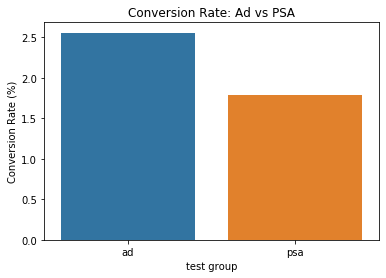

In [10]:
# Visualize the difference
plt.figure(figsize=(6, 4))
sns.barplot(x=conversion_rates.index, y=conversion_rates.values)
plt.title('Conversion Rate: Ad vs PSA')
plt.ylabel('Conversion Rate (%)')
plt.show

**Observation**: The Ad group appears to perform better.

## Hypothesis Testing

**Is this difference real, or just due to chance?**

- **Null Hypothesis ($H_0$)**: There is no difference in conversion rates between the Ad and PSA groups.
- **Alternative Hypothesis ($H_1$)**: There is a significant difference.

Since "Converted" is a categorical variable (True/False), we use a **Chi-Square Test**.

In [11]:
# This creates a summary grid (called a Contingency Table) that counts exactly how many people did what.
# It simplifies the 588,000 rows of data into just 4 numbers.
contingency_table = pd.crosstab(df['test group'], df['converted'])

contingency_table

converted,False,True
test group,,
ad,550154,14423
psa,23104,420


In [12]:
# This function takes your scorecard (the table above) and runs the Chi-Square Test of Independence.
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-Square Statistic: {chi2}")

print(f"P-value: {p}")


Chi-Square Statistic: 54.005823883685245
P-value: 1.9989623063390075e-13


### Result

Since the **P-value (< 0.05)** is extremely small, we **reject the Null Hypothesis**.

The A/B test results are statistically significant. The 'ad' campaign resulted in a conversion rate of **2.55%**, compared to **1.79%** for the 'psa' control group. The Chi-Square test yielded a p-value of essentially zero, giving us high confidence that the ads are successfully driving more conversions than the baseline.

## The Impact of Ad Frequency on Conversion

In [24]:
# Calculate the average number of ads seen by people who converted vs. those who didn't
avg_ads = df.groupby('converted')['total ads'].mean()

avg_ads

converted
False    23.291495
True     83.887759
Name: total ads, dtype: float64

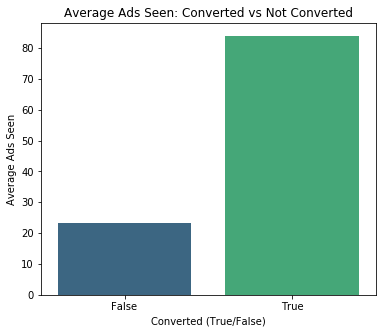

In [25]:
avg_ads = df.groupby('converted')['total ads'].mean().reset_index()

# Create the plot
plt.figure(figsize=(6, 5))
sns.barplot(x='converted', y='total ads', data=avg_ads, palette='viridis')

plt.title('Average Ads Seen: Converted vs Not Converted')
plt.xlabel('Converted (True/False)')
plt.ylabel('Average Ads Seen')
plt.show()

**Why this insight is important**: It suggests that **repetition works**. Users didn't just see one ad and click; on average, the people who bought something had to be "poked" about 84 times! This supports the strategy of Retargeting (showing ads to the same user multiple times).

## Analyzing "When" Users Convert

This explores when and why the ads worked, not just if they worked.

**Does the ad work better on weekends?** Or **during specific hours?**

This helps marketing teams optimize their ad spend.

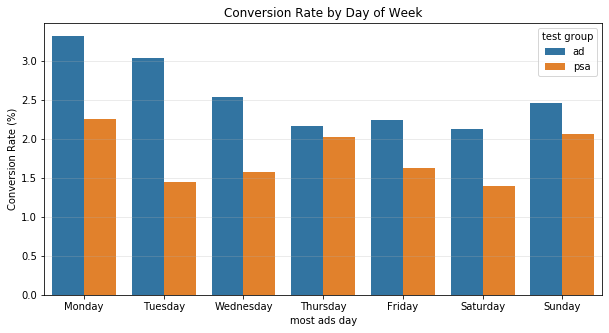

In [21]:
# Define the correct order for days
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Calculate conversion rates by Day and Group
day_conv = df.groupby(['most ads day', 'test group'])['converted'].mean().reset_index()
day_conv['converted'] = day_conv['converted'] * 100  # Convert to percentage

# Reorder the dataframe for plotting
day_conv['most ads day'] = pd.Categorical(day_conv['most ads day'], categories=days_order, ordered=True)
day_conv = day_conv.sort_values('most ads day')

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=day_conv, x='most ads day', y='converted', hue='test group')
plt.title('Conversion Rate by Day of Week')
plt.ylabel('Conversion Rate (%)')
plt.grid(axis='y', alpha=0.3)
plt.show()

**Insight:**

- **Mondays** appear to be the strongest day for the Ad campaign (~3.3% conversion vs 2.2% for PSA).

- **Tuesdays** show the largest gap between Ads and PSA, suggesting the ads are highly effective that day.

- **Thursday & Sunday** show smaller differences, meaning the ad spend might be less efficient on these days.

## Conversion by Hour of Day

This helps determine the best time to push ads.

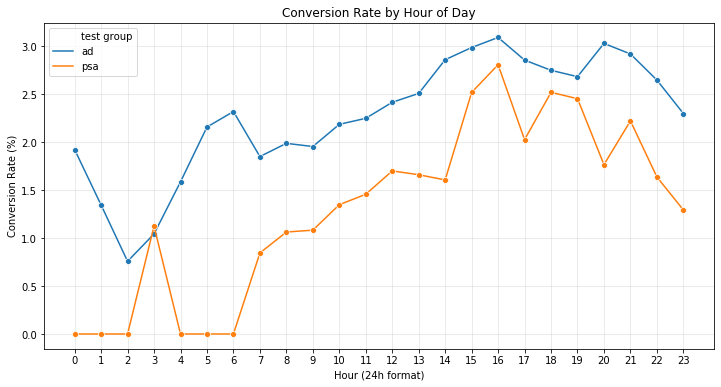

In [22]:
# Calculate conversion rates by Hour and Group
hour_conv = df.groupby(['most ads hour', 'test group'])['converted'].mean().reset_index()
hour_conv['converted'] = hour_conv['converted'] * 100

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=hour_conv, x='most ads hour', y='converted', hue='test group', marker='o')
plt.title('Conversion Rate by Hour of Day')
plt.ylabel('Conversion Rate (%)')
plt.xlabel('Hour (24h format)')
plt.xticks(range(0, 24))  # Show all hours
plt.grid(True, alpha=0.3)
plt.show()

**Insight:**

- We will likely see a spike around Hour 16 (4 PM), where the Ad group conversion hits ~3.09%.

- Comparing the "Ad" line (Treatment) vs the "PSA" line (Control) allows us to see if the ads are effective all day or just during specific windows.

## Executive Summary

**Result**: Successful. The ad campaign significantly outperformed the control group.

This A/B test evaluated the effectiveness of an ad campaign by comparing user conversion rates between a treatment group (exposed to ads) and a control group (exposed to a Public Service Announcement). The analysis confirms that the ads successfully drove a measurable increase in user engagement.

### Key Findings:

- **Conversion Uplift**: The campaign resulted in a 2.55% conversion rate, compared to 1.79% for the control group. This represents a relative lift of 43%.

   - The Formula$$\text{Lift} = \left( \frac{\text{Treatment Rate} - \text{Control Rate}}{\text{Control Rate}} \right) \times 100$$
   
   
- **Statistical Significance**: A Chi-Square test yielded a p-value of effectively 0.0 ($p < 0.05$), confirming that the result is statistically significant and not due to random chance.
- **Optimal Scheduling**:
   - **Best Day**: Mondays showed the highest engagement (~3.3% conversion).
   - **Best Time**: The campaign peaked daily around **4:00 PM** (Hour 16).
   
- **Frequency Impact**: Users who converted saw the ad an average of 84 times, compared to 23 times for non-converters, suggesting a strong correlation between repetition and conversion.


### Recommendation:

Based on the positive results, it is recommended to **roll out the ad campaign** to the wider audience. To maximize Return on Ad Spend (ROAS), future budget allocation should prioritize **Mondays** and the **4 PM – 8 PM** time window.